In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Read annotated data

In [2]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Look for missing values:

<Axes: >

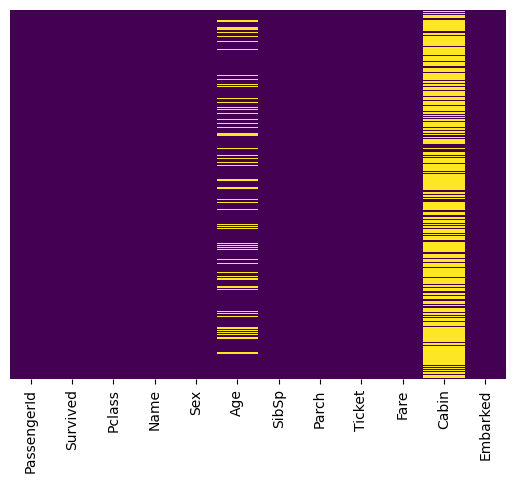

In [5]:
sns.heatmap(train.isnull(), cmap='viridis', yticklabels=False, cbar=False)

Need to fill average age per passenger class (proxy for socioeconomic status (SES))

What's the average age per passenger class?

In [6]:
train.groupby(by='Pclass')['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

Let's round values

In [7]:
train.groupby(by='Pclass')['Age'].mean().map(round)

Pclass
1    38
2    30
3    25
Name: Age, dtype: int64

We can turn this into a dictionary to then map that to the missing values

In [8]:
avg_ages = dict(train.groupby(by='Pclass')['Age'].mean().map(round))
avg_ages

{1: 38, 2: 30, 3: 25}

A series where each age value is set to the respective Pclass mean:

In [9]:
train['Pclass'].map(avg_ages)

0      25
1      38
2      25
3      38
4      25
       ..
886    30
887    38
888    25
889    38
890    25
Name: Pclass, Length: 891, dtype: int64

Now fill missing values with the corresponding entry from that series:

In [10]:
train['Age'].fillna(train['Pclass'].map(dict(train.groupby(by='Pclass')['Age'].mean().map(round))), inplace=True)

<Axes: >

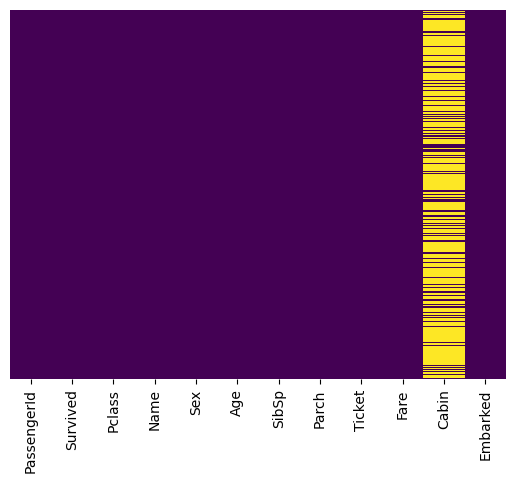

In [11]:
sns.heatmap(train.isnull(), cmap='viridis', yticklabels=False, cbar=False)

This is looking a lot better. Cabin is mostly empty so we'll drop it:

In [12]:
train.drop(columns='Cabin', inplace=True)

Sex, Embarked and Passenger Class are best expressed as independent categoricals:

In [13]:
train = pd.get_dummies(train, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)

This is how we're looking so far:

In [14]:
train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,0,1,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,0,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,0,1,0,1


The ticket column could hold some valuable data, let's see if we can extract that:

In [15]:
unique_tickets = train['Ticket'].map(str.split).map(lambda l: l[0]).value_counts()
unique_tickets

PC        60
C.A.      27
STON/O    12
A/5       10
W./C.      9
          ..
113043     1
28551      1
345364     1
234818     1
370376     1
Name: Ticket, Length: 557, dtype: int64

In [16]:
unique_tickets.index

Index(['PC', 'C.A.', 'STON/O', 'A/5', 'W./C.', 'SOTON/O.Q.', 'CA.', '1601',
       'SOTON/OQ', 'A/5.',
       ...
       '244361', '248740', '113784', '7598', '349225', '113043', '28551',
       '345364', '234818', '370376'],
      dtype='object', length=557)

In [17]:
unique_tickets.index.map(lambda s: s[0].lower() in 'abcdefghijklmnopqrstuvwxyz')

Index([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
       ...
       False, False, False, False, False, False, False, False, False, False],
      dtype='bool', length=557)

All alphabetic labels from the tickets:

In [18]:
ticket_alpha = unique_tickets.index[unique_tickets.index.map(lambda s: s[0].lower() in 'abcdefghijklmnopqrstuvwxyz')]
ticket_alpha

Index(['PC', 'C.A.', 'STON/O', 'A/5', 'W./C.', 'SOTON/O.Q.', 'CA.', 'SOTON/OQ',
       'A/5.', 'STON/O2.', 'CA', 'C', 'SC/PARIS', 'F.C.C.', 'S.O.C.', 'LINE',
       'SC/Paris', 'S.O./P.P.', 'SC/AH', 'PP', 'A/4.', 'A/4', 'SOTON/O2',
       'A.5.', 'A./5.', 'P/PP', 'WE/P', 'S.C./PARIS', 'S.W./PP', 'C.A./SOTON',
       'F.C.', 'Fa', 'S.O.P.', 'A4.', 'SW/PP', 'W/C', 'S.C./A.4.', 'W.E.P.',
       'SO/C', 'S.P.', 'SCO/W', 'SC', 'A/S'],
      dtype='object')

Overall Fare:

<Axes: xlabel='Fare', ylabel='Count'>

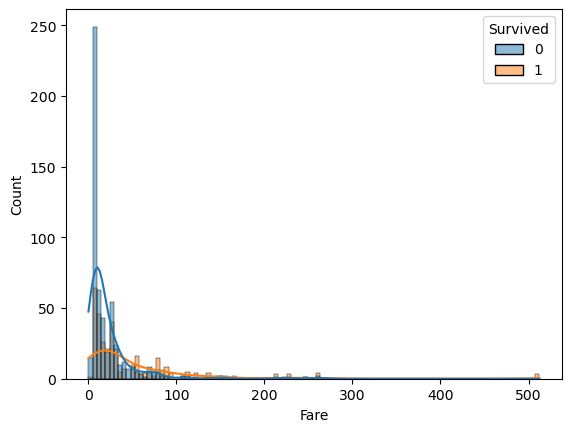

In [19]:
sns.histplot(train, x='Fare', kde=True, hue='Survived')

<Axes: xlabel='Fare', ylabel='Count'>

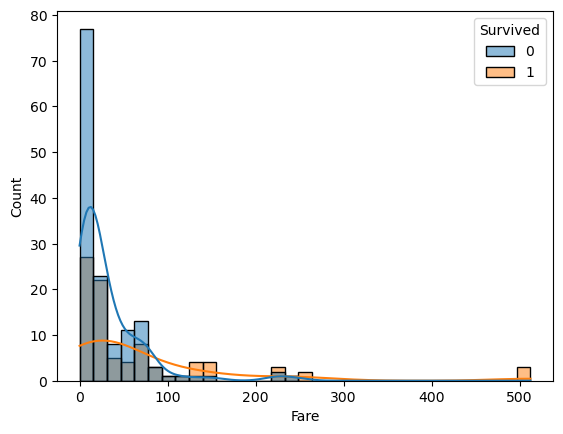

In [20]:
sns.histplot(train[train['Ticket'].map(str.split).map(lambda l: l[0] in ticket_alpha)], x='Fare', kde=True, hue='Survived')

No real visible difference; the best we can do is add a column with special labels

In [21]:
train['Ticket_alpha'] = train['Ticket'].map(str.split).map(lambda l: l[0]).map(lambda a: 1 if a[0].lower() in 'abcdefghijklmnopqrstuvwxyz' else 0)

In [22]:
train.drop(columns='Ticket', inplace=True)

In [23]:
train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Ticket_alpha
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,1,0,1,0,1,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,0,0,0,0,0,1
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,0,0,1,0,1,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,0,0,1,0,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,8.0500,1,0,1,0,1,0


Anything interesting in the name?

Here are all the titles, we can turn that into dummy columns

In [24]:
train['Name'].map(str.split).map(lambda l: l[1]).value_counts()

Mr.             502
Miss.           179
Mrs.            121
Master.          40
Dr.               7
Rev.              6
y                 4
Planke,           3
Impe,             3
Gordon,           2
Col.              2
Mlle.             2
Major.            2
Melkebeke,        1
Jonkheer.         1
Shawah,           1
the               1
Velde,            1
Capt.             1
Messemaeker,      1
Carlo,            1
Ms.               1
Mme.              1
Steen,            1
Mulder,           1
Pelsmaeker,       1
Walle,            1
der               1
Billiard,         1
Don.              1
Cruyssen,         1
Name: Name, dtype: int64

Note that titles end with a period. Let's eliminate the rest:

In [25]:
train['Name'].map(str.split).map(lambda l: l[1]).map(lambda s: s if s[-1] == '.' else 'No Title').value_counts()

Mr.          502
Miss.        179
Mrs.         121
Master.       40
No Title      25
Dr.            7
Rev.           6
Major.         2
Mlle.          2
Col.           2
Don.           1
Mme.           1
Ms.            1
Capt.          1
Jonkheer.      1
Name: Name, dtype: int64

In [26]:
train['Name'].map(str.split).map(lambda l: l[1]).map(lambda s: 1 if s[-1] == '.' else 0)

0      1
1      1
2      1
3      1
4      1
      ..
886    1
887    1
888    1
889    1
890    1
Name: Name, Length: 891, dtype: int64

In [27]:
train['Title'] = train['Name'].map(str.split).map(lambda l: l[1]).map(lambda s: 1 if s[-1] == '.' else 0)

In [28]:
train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Ticket_alpha,Title
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,1,0,1,0,1,1,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,0,0,0,0,0,1,1
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,0,0,1,0,1,1,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,0,0,1,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,8.0500,1,0,1,0,1,0,1


In [29]:
train.drop(columns=['Name'], inplace=True)

# Training Data Split

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X = train.drop(columns=['Survived'])
y = train['Survived']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Model Training

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
lr = LogisticRegression(max_iter=2000)

In [35]:
lr.fit(X=X, y=y)

LogisticRegression(max_iter=2000)

In [36]:
predictions = lr.predict(X_test)

# Verifying

In [37]:
from sklearn.metrics import classification_report

In [38]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       171
           1       0.79      0.68      0.73        97

    accuracy                           0.82       268
   macro avg       0.81      0.79      0.80       268
weighted avg       0.81      0.82      0.81       268



# Training on the entire dataset

In [39]:
test = pd.read_csv('titanic_test.csv')

<Axes: >

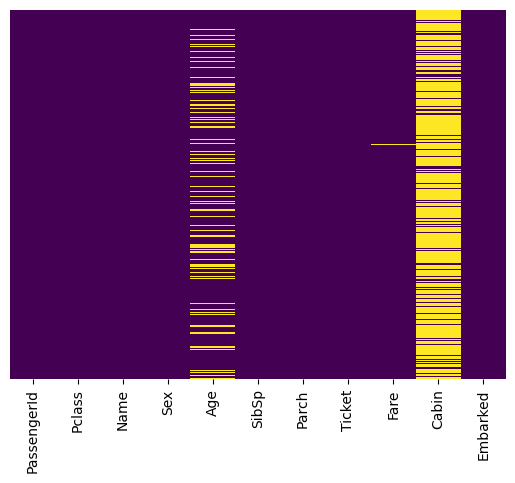

In [40]:
sns.heatmap(test.isnull(), cmap='viridis', yticklabels=False, cbar=False)

In [41]:
test['Age'] = test['Age'].fillna(test['Pclass'].map(avg_ages))

<Axes: >

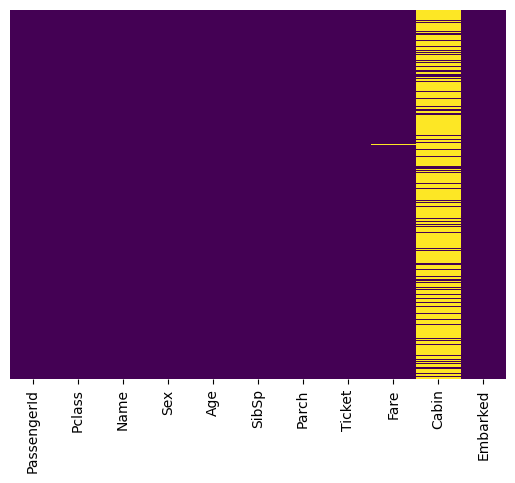

In [42]:
sns.heatmap(test.isnull(), cmap='viridis', yticklabels=False, cbar=False)

One fare value is missing. We need to predict via linear regression:

In [43]:
from sklearn.linear_model import LinearRegression

In [44]:
lm = LinearRegression()

In [45]:
X_fare = train.drop(columns=['Fare', 'Survived'])
y_fare = train['Fare']

In [46]:
X_fare_train, X_fare_test, y_fare_train, y_fare_test = train_test_split(X_fare, y_fare, test_size=0.3)

In [47]:
lm.fit(X_fare_train, y_fare_train)

LinearRegression()

In [48]:
predictions = lm.predict(X_fare_test)

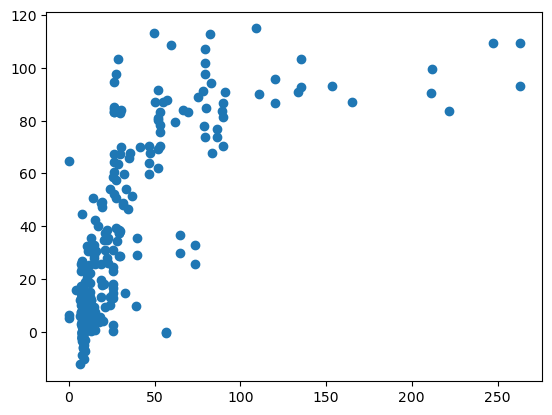

In [49]:
plt.scatter(x=y_fare_test, y=predictions)

C:\Users\schat\AppData\Local\Temp\ipykernel_10332\1223058047.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_fare_test-predictions),bins=50);


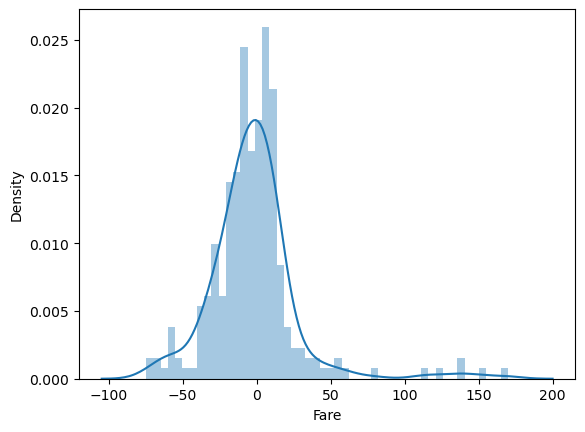

In [50]:
sns.distplot((y_fare_test-predictions),bins=50);

In [51]:
pd.DataFrame(lm.coef_,X_fare.columns,columns=['Coefficient'])

,Coefficient
PassengerId,0.003601
Age,-0.301242
SibSp,5.228157
Parch,7.429338
Sex_male,-8.959518
Embarked_Q,-10.686444
Embarked_S,-15.533418
Pclass_2,-63.402390
Pclass_3,-71.196499
Ticket_alpha,17.232484


Data processing as before:

In [52]:
test = pd.get_dummies(test, columns=['Sex', 'Embarked', 'Pclass'], drop_first=True)

In [53]:
test['Ticket_alpha'] = test['Ticket'].map(str.split).map(lambda l: l[0]).map(lambda a: 1 if a[0].lower() in 'abcdefghijklmnopqrstuvwxyz' else 0)

In [54]:
test['Title'] = test['Name'].map(str.split).map(lambda l: l[1]).map(lambda s: 1 if s[-1] == '.' else 0)

In [55]:
test.drop(columns=['Cabin', 'Name', 'Ticket'], inplace=True)

Where is the value missing?

In [56]:
test[test['Fare'].isnull()]

,PassengerId,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Ticket_alpha,Title
152,1044,60.5,0,0,NaN,1,0,1,0,1,0,1


In [57]:
lm.predict(test[test['Fare'].isnull()].drop(columns='Fare'))

array([-9.71809196])

In [58]:
test['Fare'].describe()

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

In [59]:
test['Fare'].value_counts()[0]

2

Two people actually went for free. We will assume that the missing value also didn't pay for the ticket

In [60]:
test['Fare'] = test['Fare'].fillna(0)

In [61]:
lr_big = LogisticRegression(max_iter=2000)

Training on the entire training data this time:

In [62]:
lr_big.fit(X=train.drop(columns='Survived'), y=train['Survived'])

LogisticRegression(max_iter=2000)

In [63]:
pred_big = lr_big.predict(test)

In [65]:
pred_big

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [77]:
test

,PassengerId,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Ticket_alpha,Title
0,892,34.5,0,0,7.8292,1,1,0,0,1,0,1
1,893,47.0,1,0,7.0000,0,0,1,0,1,0,1
2,894,62.0,0,0,9.6875,1,1,0,1,0,0,1
3,895,27.0,0,0,8.6625,1,0,1,0,1,0,1
4,896,22.0,1,1,12.2875,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,25.0,0,0,8.0500,1,0,1,0,1,1,1
414,1306,39.0,0,0,108.9000,0,0,0,0,0,1,0
415,1307,38.5,0,0,7.2500,1,0,1,0,1,1,1
416,1308,25.0,0,0,8.0500,1,0,1,0,1,0,1


In [78]:
submission = pd.DataFrame(pred_big, columns=['Survived'], index=test['PassengerId'])
submission

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [79]:
submission.to_csv('submission.csv')